# 输入数据模块

In [1]:
import csv
import json
import linecache
import datetime
import sys
import numpy as np
import random
from scipy.sparse import *
from scipy import *
import scipy as sp
import matplotlib.pyplot as plt
import os.path
import matplotlib
import copy
import pandas as pd
from scipy import stats
from tempfile import TemporaryFile
import pickle
from scipy.integrate import odeint
from torchdiffeq import odeint as dodeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import country_converter as coco

def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()
    

## Import Data

### Country_names combination

In [21]:

# 首先，我们要校准各个国家的名称，做法是分别把航空流量数据、国家人口数据和病例数据中的国家字段都加载进来，统一转换为标准国家名称
# flow data
first_date = datetime.datetime(2019, 12, 1, 0, 0)
day_len = (datetime.datetime.strptime('2020-12-31','%Y-%m-%d') - first_date).days
fijt = []
countries = set([])
for day in range(day_len):
    dd=(first_date+datetime.timedelta(days=day)).strftime("%Y-%m-%d")
    flushPrint(dd)
    filename = 'data/country_flow/'+dd+'.csv'
    df=pd.read_csv(filename)
    countries1=set(df['Unnamed: 0'])
    countries2=set(list(df.columns)[1:])
    countries = countries | countries1 | countries2
    flushPrint(len(countries))
countries_temp = list(coco.convert(names=countries, to="name_short"))
countries1 = set(countries_temp)

name_map = {}
for i,cc in enumerate(countries):
    vv = name_map.get(cc, '')
    if len(vv) == 0:
        name_map[cc] = countries_temp[i]
print(len(countries), len(countries1))

# case data
df = pd.read_csv('data/global0415_en.csv')
countries = set(df['country'][1:])
countries2 = set(coco.convert(names=countries, to="name_short"))
print(len(countries), len(countries2))

# population data
df = pd.read_csv('data/country_population.csv')
countries=set(df['Name'][1:])
countries3 = set(coco.convert(names=countries, to="name_short"))
print(len(countries), len(countries3))

countries = countries1 | countries2 | countries3
nodes = {}
for country in countries:
    if country != 'not found':
        idx = nodes.get(country, len(nodes))
        nodes[country] = idx

#这一步的输出结果主要是一个字典nodes，国家名称作为key，国家在nodes中的位置作为value，这个值也是后面各个数组的国家索引
#另外还输出一个name_map，它的作用是把不标准的国家名称映射为标准名称

2260-12-30

226 226


206 202
248 247


### Read Population

In [22]:
#开始正是读取人口数据
df = pd.read_csv('data/country_population.csv')
country_properties1 = {}
for index, row in df.iterrows():
    try:
        ccc = coco.convert(names=row['Name'], to="name_short")
        country_properties1[ccc] = float(row['Population'])
    except:
        print(row['Name'])
        print(row['Population'])
        
country_pop = {}
print('second')
for country, i in nodes.items():
    if country_pop.get(country, -1)>0:
        print('duplicate:', country)
    else:
        pop = country_properties1.get(country, 1)
        country_pop[country] = pop
print('These countries have no pop data:')
for k,v in country_pop.items():
    if v <= 0:
        print(k)
population = np.ones(len(nodes))
for cc,i in nodes.items():
    population[i] = country_pop.get(cc, 1.0)
#这部分输出是数组population，国家的顺序按照nodes中记载的顺序来，以及一个字典country_pop，key为国家名，value为人口数

Bouvet Island
QuantityMagnitude[Missing["NoResidentPopulation"]]
second
These countries have no pop data:


### Real Flow Dynamics

In [23]:
# Read inter-country flow data day by day:
#读取航空流量数据，从2019年12月1日到2020年12月31日
first_date = datetime.datetime(2019, 12, 1, 0, 0)
day_len = (datetime.datetime.strptime('2020-12-31','%Y-%m-%d') - first_date).days
fijt = []
for day in range(day_len):
    dd=(first_date+datetime.timedelta(days=day)).strftime("%Y-%m-%d")
    flushPrint(dd)
    filename = 'data/country_flow/'+dd+'.csv'
    df=pd.read_csv(filename)
    fij = np.zeros([len(nodes), len(nodes)])
    for index, row in df.iterrows():
        
        for i,content in enumerate(row.iteritems()):
            if i==0:
                country_i = name_map[content[1]]
            else:
                country_j = name_map[content[0]]
                if country_j!='not found' and country_i!='not found':
                    if country_pop[country_i] > 0:
                        fij[nodes[country_i], nodes[country_j]] += float(content[1])
                    else:
                        fij[nodes[country_i], nodes[country_j]] += 0#float(content[1])
                    if nodes[country_i]==nodes[country_j]:
                        fij[nodes[country_i], nodes[country_j]] = 0
    for k,pop in country_pop.items():
        flux1 = fij[nodes[k],:].sum()
        flux2 = fij[:, nodes[k]].sum()
        flux =max(flux1, flux2)
        if flux > country_pop[k]:
            country_pop[k] = flux
            population[nodes[k]] = flux
        fij[nodes[k],:] = fij[nodes[k],:] /country_pop[k]
    
    fijt.append(fij)
    
#输出为一个列表fijt，记录每一天的流量矩阵。流量矩阵fij表示从i到j的流占国家i总人口的比例

2020-12-30

### Case data

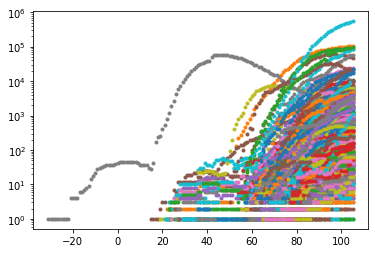

In [24]:
# 读取病例数据，从2019年12月1日，到2020年4月15日
df = pd.read_csv('data/global0415_en.csv')

all_cases_countries = list(set(df['country']))[1:]

china=df.loc[df['country']=='China',['cum_confirm','time','cum_heal','cum_dead']]
dates = list(china['time'])
sorted_dates = np.sort(dates)
first_date = datetime.datetime(2020, 1, 1, 0, 0)
start_date = datetime.datetime(2019, 12, 1, 0, 0)
day_len = (datetime.datetime.strptime('2020/4/16','%Y/%m/%d') - start_date).days
first_cases = int(china.loc[china['time']=='2019/12/1']['cum_confirm'])

all_confirmed_cases = np.zeros([day_len, len(nodes)])
all_cued_cases = np.zeros([day_len, len(nodes)])
all_death_cases = np.zeros([day_len, len(nodes)])
for country in all_cases_countries:
    #country = country_map2.get(country, country)
    ccc = coco.convert(names=country, to="name_short")
    if nodes.get(ccc, -1)>=0:
        subset = df.loc[df['country']==country,['cum_confirm','time','cum_heal','cum_dead']]
        if len(subset)>0:
            new_cases = np.array(subset['cum_confirm'])
            cued_cases = np.array(subset['cum_heal'])
            die_cases = np.array(subset['cum_dead'])


            dates = list(subset['time'])
            new_cases = np.r_[new_cases[0],np.diff(new_cases)]
            cued_cases = np.r_[cued_cases[0],np.diff(cued_cases)]
            die_cases = np.r_[die_cases[0],np.diff(die_cases)]
            for i,dd in enumerate(dates):
                if pd.isnull(dd):
                    dd = dates1[i]
                if not pd.isnull(dd):

                    day=(datetime.datetime.strptime(dd,'%Y/%m/%d') - start_date).days
                    all_confirmed_cases[day, nodes[ccc]] += new_cases[i]
                    all_cued_cases[day, nodes[ccc]] += cued_cases[i]
                    all_death_cases[day, nodes[ccc]] += die_cases[i]

time_cases = np.arange(day_len) - (first_date - start_date).days
all_cumconfirm_cases = np.cumsum(all_confirmed_cases, 0) - np.cumsum(all_cued_cases, 0) - np.cumsum(all_death_cases, 0)
all_cumexist_cases = np.cumsum(all_confirmed_cases, 0)
for i in range(all_cumconfirm_cases.shape[1]):
    yy = all_cumconfirm_cases[:, i]
    bools = yy>0
    plt.semilogy(time_cases[bools], yy[bools],'.')
plt.show()


targets = torch.cat((torch.Tensor(all_cumconfirm_cases), torch.Tensor(all_cumexist_cases)),1)
for i in range(len(population)):
    targets[:, i] /= population[i]
    targets[:, len(nodes)+i]/=population[i]
    if population[i]==1:
        targets[:,i] = 0
        targets[:,i+len(nodes)]=1
mask = targets > 0

#这部分输出有如下一些数据：
#1、first_date：2020年1月1日，是我们的时间0点
#2、start_date: 2019年12月1日，是病例数据起始的0点
#3、all_cumconfirm_cases: 是一个time_length*国家数的而为数组，记录了某一天现存的确诊病例数，这里time_length就是12-1日到4-15日的时间
#4、all_cumexist_cases：是一个time_length*国家数的而为数组，记录了某一天累积的确诊病例数
#5、targets，是一个Tensor，time_length*2*国家数维度，将all_cumconfirm_cases和all_cumexist_cases合并到了一起，作为训练的target
#6、mask：是一个Tensor，time_length*2*国家数维度，0-1矩阵，记录了targets是否>0的情况
#7、first_cases: 在2019年12月1日，中国的确诊病例数

### Computing controlled t0

Uruguay [126]


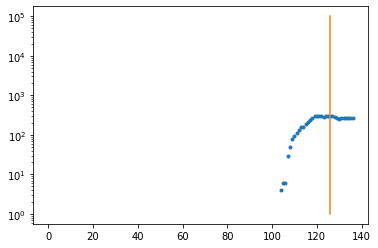

Cameroon [134]


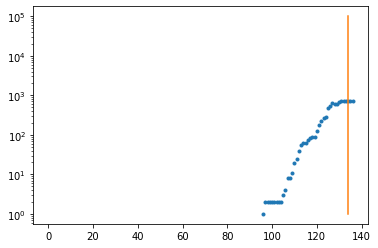

Kuwait [136]


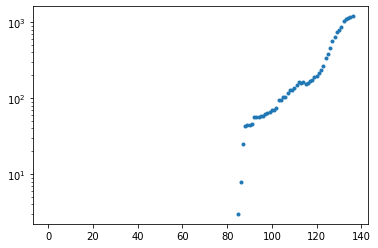

Bahrain [136]


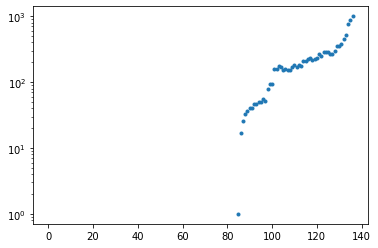

Germany [127]


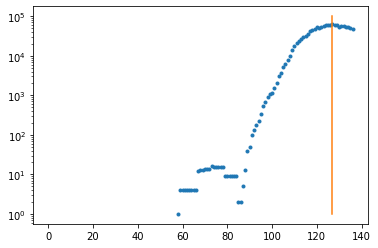

Cuba [136]


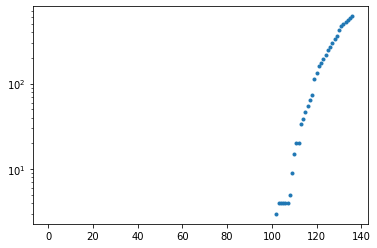

Turks and Caicos Islands [135 136]


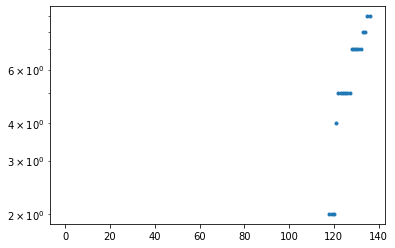

Sweden [135 136]


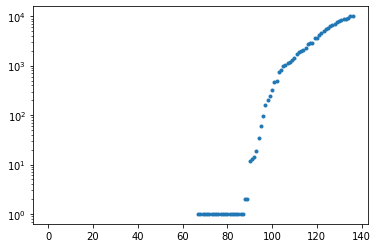

Italy [136]


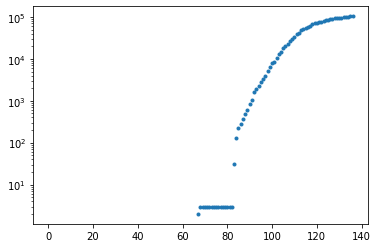

Nepal [135 136]


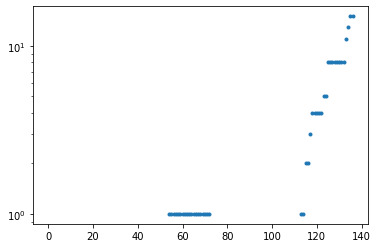

Thailand [126]


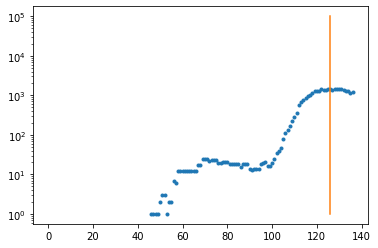

Equatorial Guinea [136]


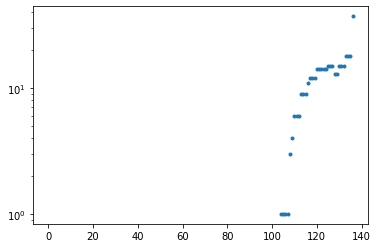

Uzbekistan [136]


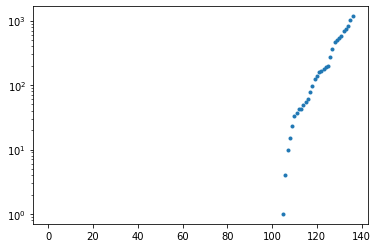

Austria [122]


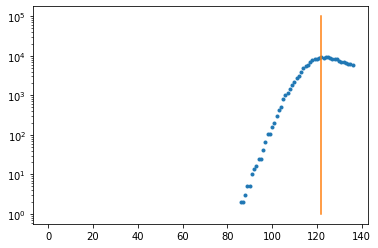

Lithuania [136]


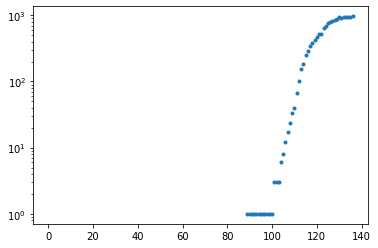

Hungary [136]


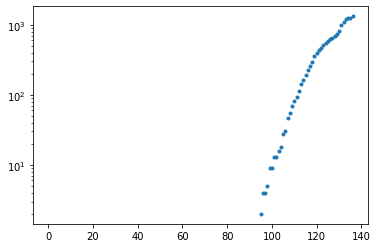

Vietnam [119]


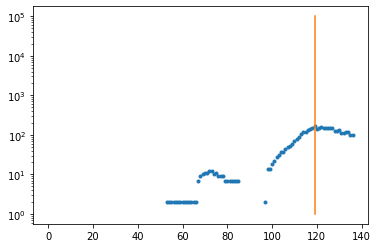

Montserrat [134 135 136]


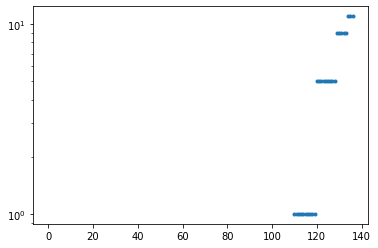

Faeroe Islands [124]


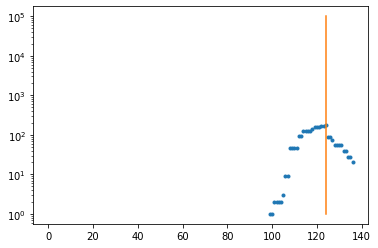

Kyrgyz Republic [136]


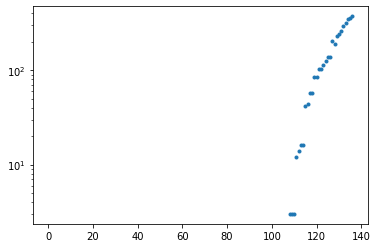

Maldives [105 106 107 108 109 110 111 112 113 114]


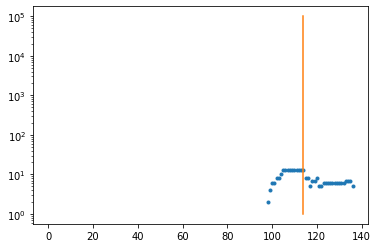

Isle of Man [127]


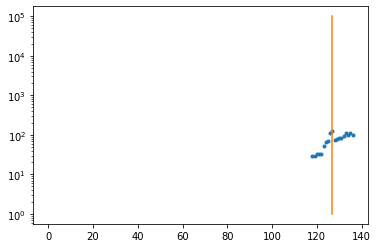

Burkina Faso [135]


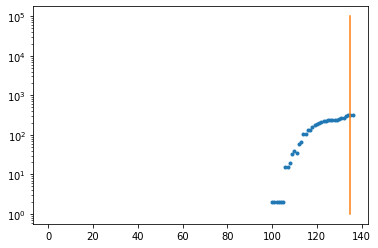

Greece [136]


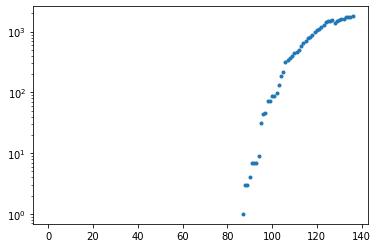

Cyprus [136]


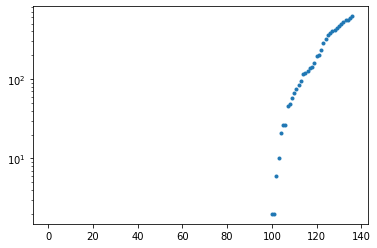

Puerto Rico [136]


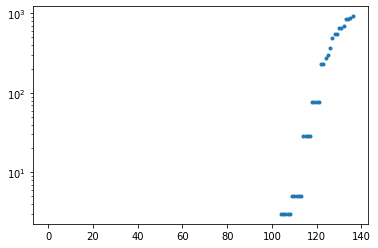

Bahamas [135 136]


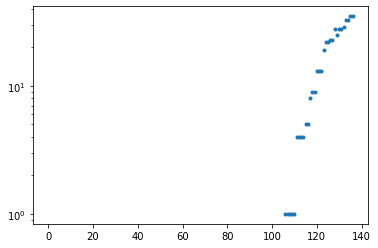

Finland [136]


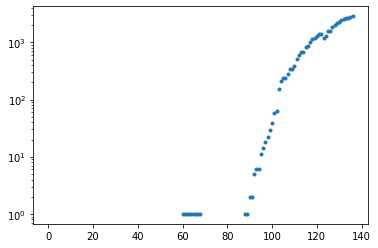

Japan [136]


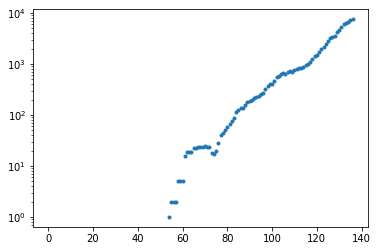

Martinique [127]


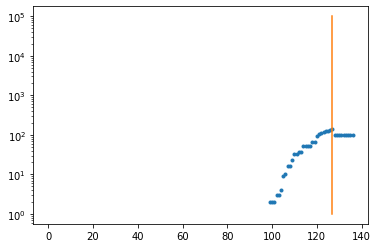

Bermuda [128 129]


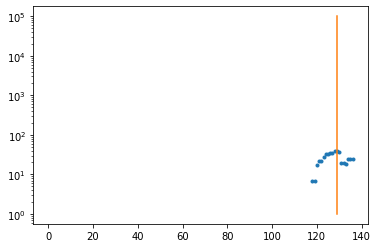

Mozambique [136]


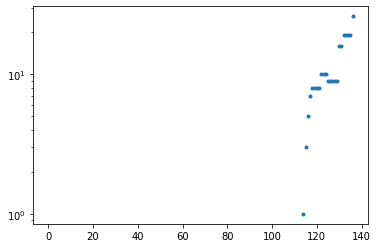

Malawi [136]


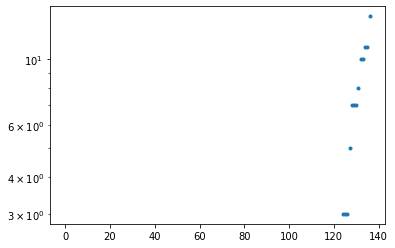

French Polynesia [135 136]


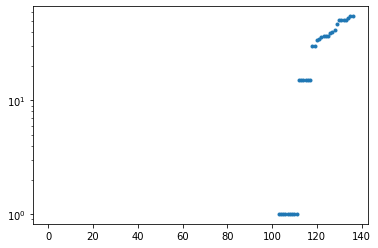

Rwanda [132]


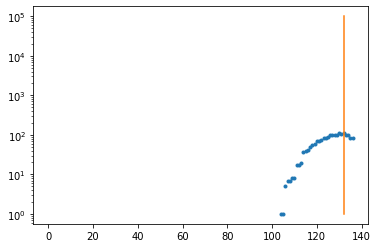

South Africa [135 136]


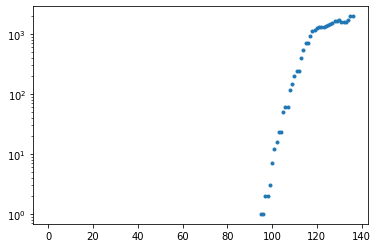

Barbados [135 136]


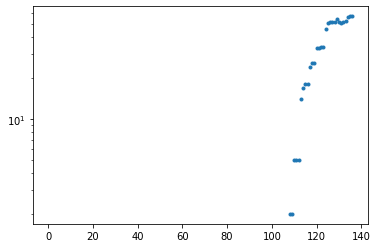

Luxembourg [136]


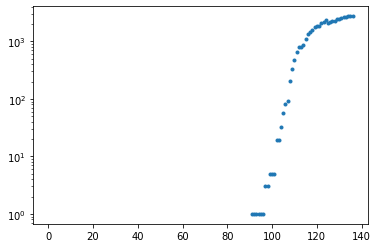

Guinea-Bissau [136]


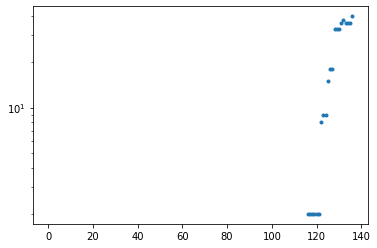

Gibraltar [127]


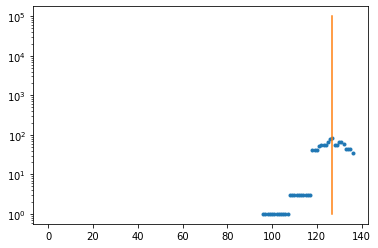

Jamaica [136]


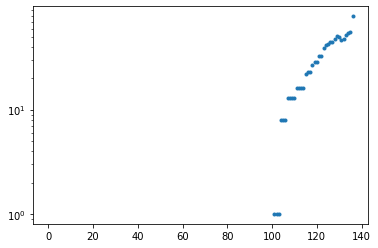

Malaysia [126]


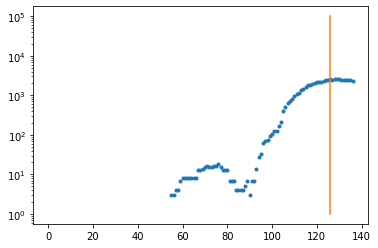

Sri Lanka [136]


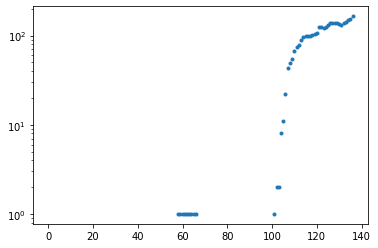

Ecuador [134]


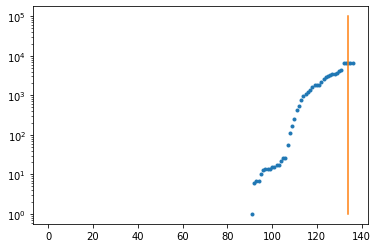

Albania [127]


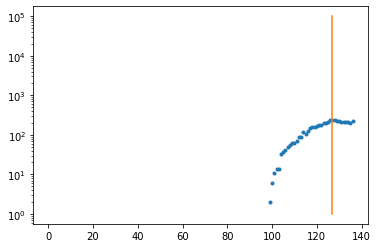

Bhutan [124 125 126 127 128 129 130]


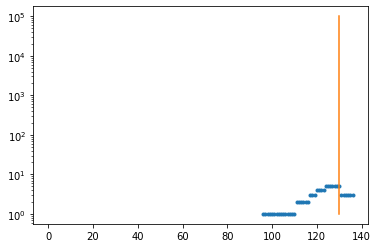

Gabon [136]


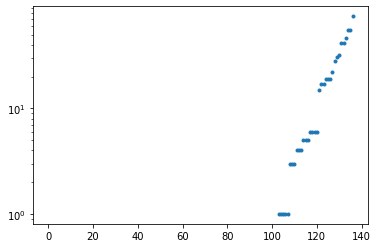

Seychelles [128 129 130 131 132 133 134 135 136]


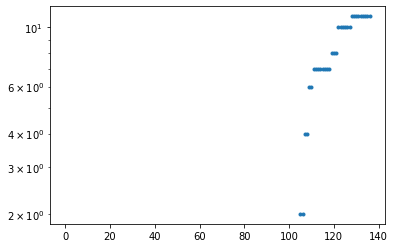

Indonesia [136]


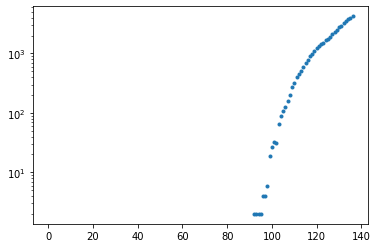

Mauritius [132]


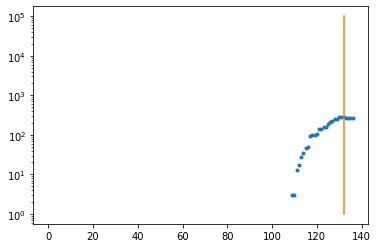

Venezuela [127]


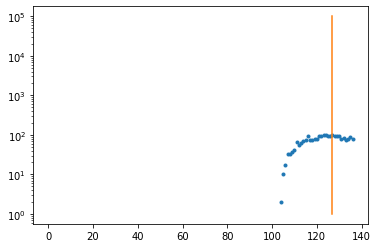

Sao Tome and Principe [127 128 129 130 131 132 133 134 135 136]


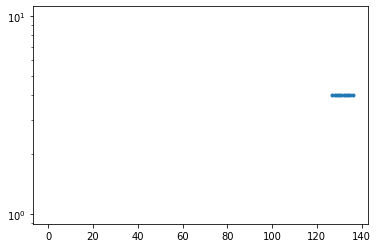

Slovenia [136]


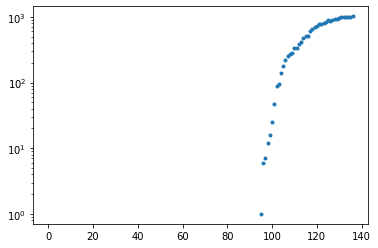

Switzerland [122]


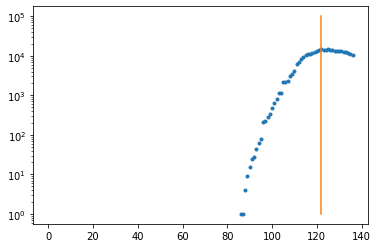

Angola [130 131 132]


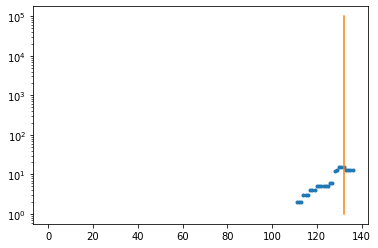

Bulgaria [136]


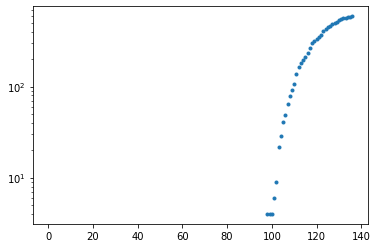

New Zealand [128]


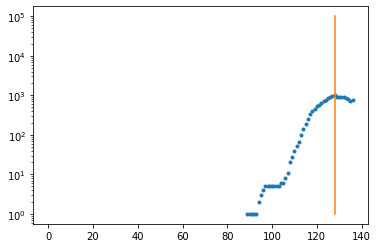

Congo Republic [136]


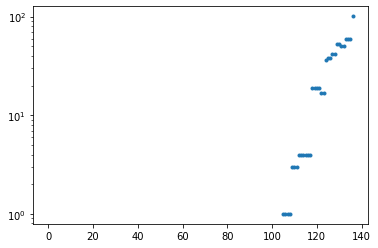

Botswana [130 131 132 133 134 135 136]


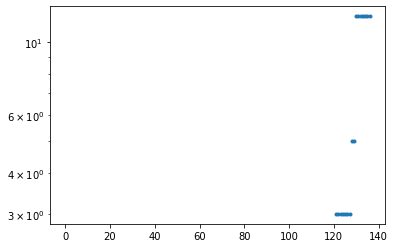

Iraq [129]


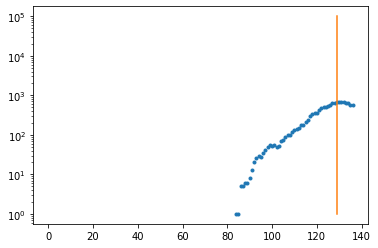

Reunion [135 136]


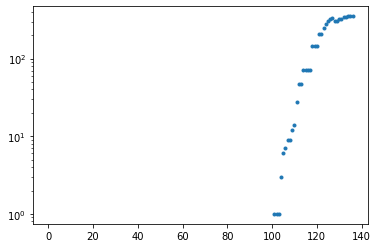

Guyana [135 136]


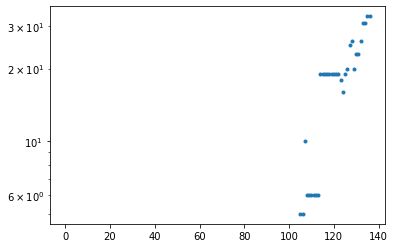

Fiji [131 132 133 134 135 136]


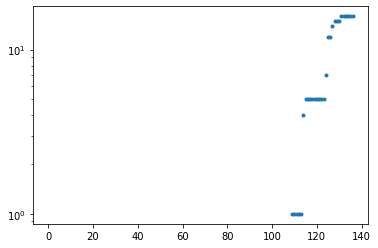

Czech Republic [134 135]


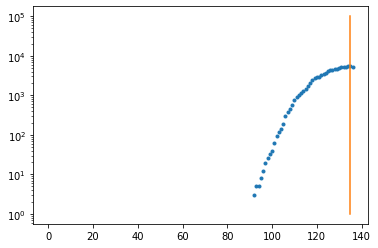

Guinea [136]


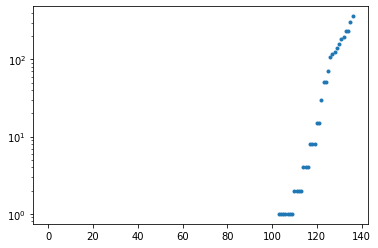

Uganda [134 135]


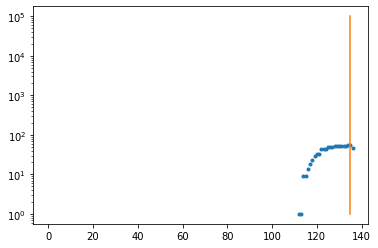

Grenada [132 133 134 135 136]


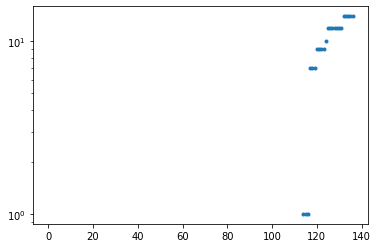

Haiti [135 136]


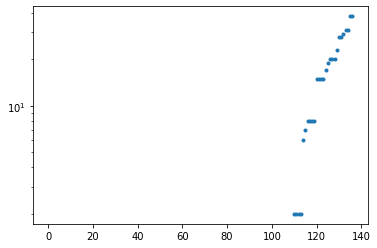

Sudan [136]


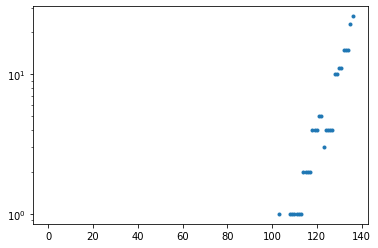

Peru [136]


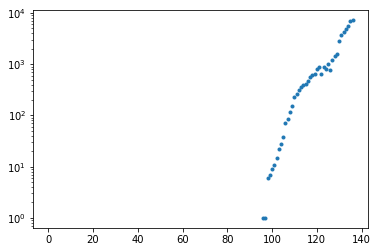

Netherlands [136]


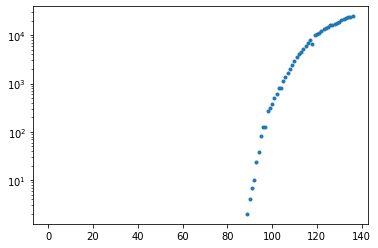

Turkey [136]


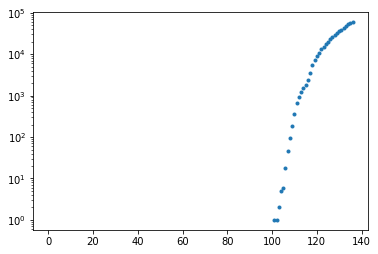

Panama [136]


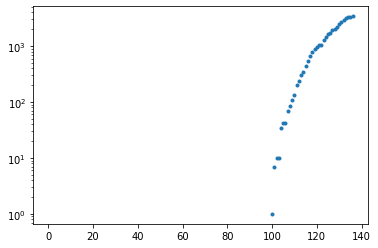

Dominica [128]


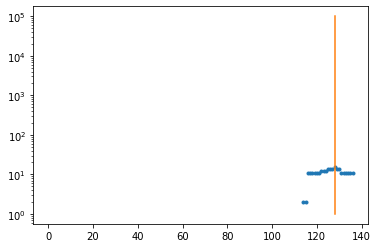

Norway [136]


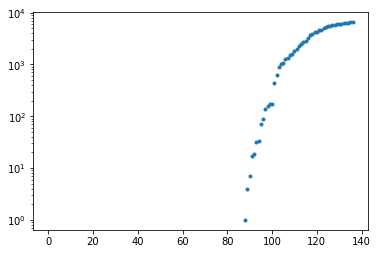

Timor-Leste [136]


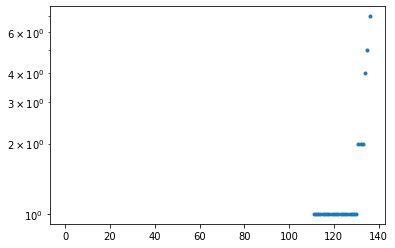

Montenegro [135]


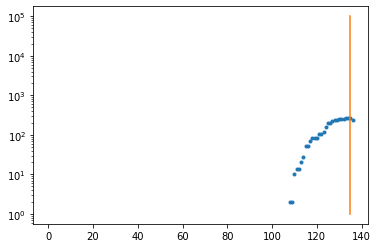

Somalia [135 136]


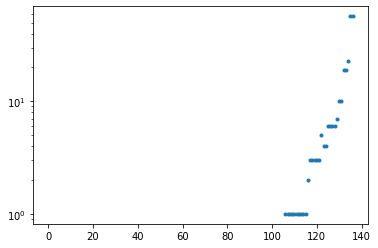

Eswatini [118 119 120 121 122 128]


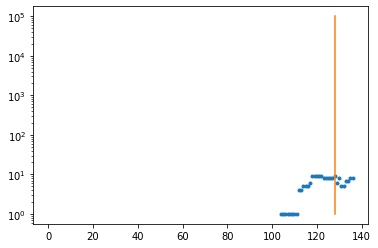

Liechtenstein [126 127 128]


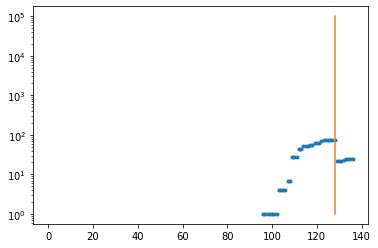

Slovakia [136]


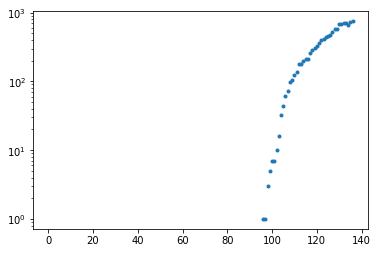

Ghana [136]


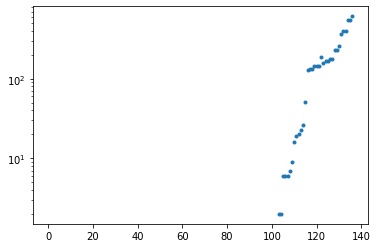

DR Congo [136]


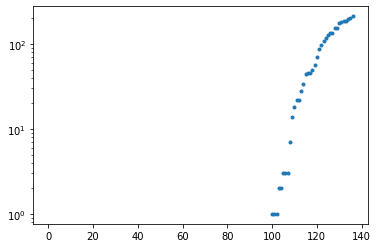

Singapore [136]


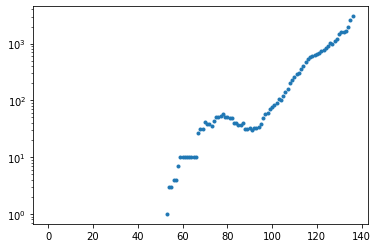

Paraguay [136]


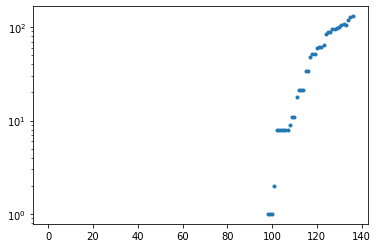

Bolivia [136]


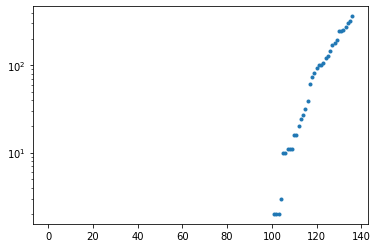

Oman [136]


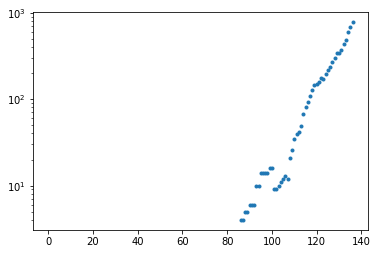

Canada [136]


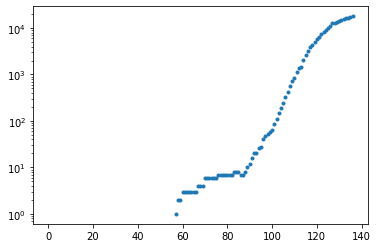

South Korea [102]


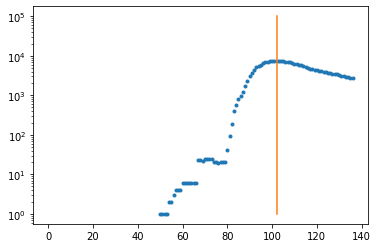

Croatia [131]


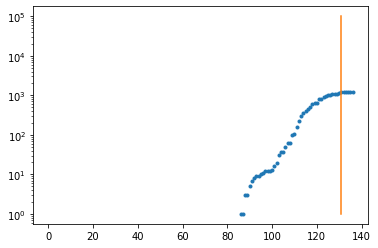

Bosnia and Herzegovina [136]


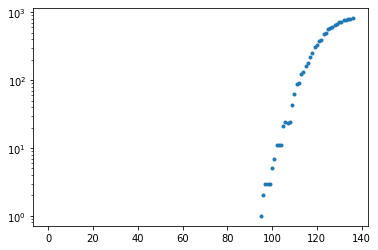

Malta [136]


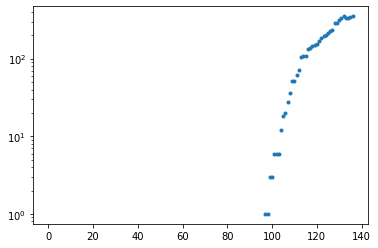

Niger [136]


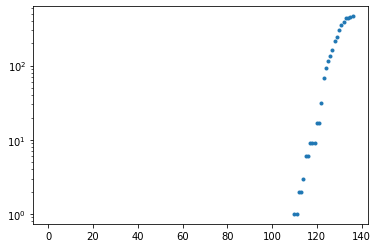

Armenia [134]


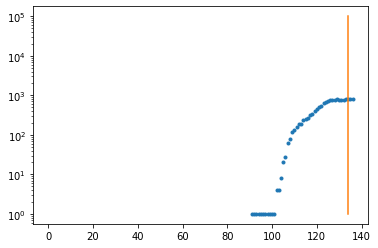

Dominican Republic [136]


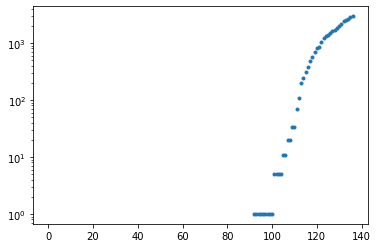

Suriname [123 124 125 126 127 128]


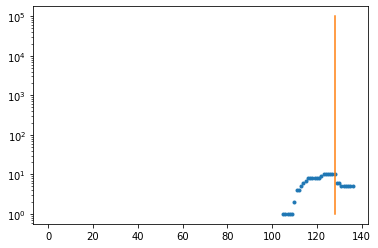

St. Pierre and Miquelon [126 127 128 129 130 131 132 133 134 135 136]


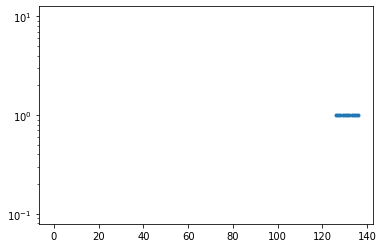

Guadeloupe [126 127]


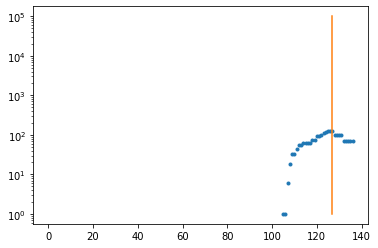

Romania [135]


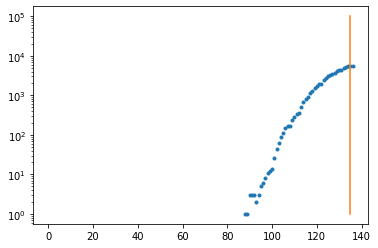

Moldova [136]


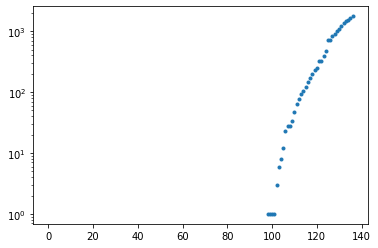

Namibia [126 127 128 129 130 131 132 133 134 135 136]


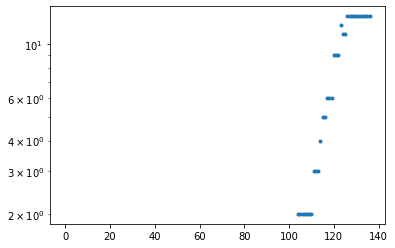

Mexico [134]


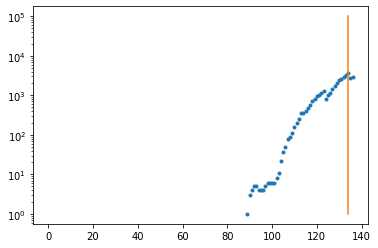

Gambia [136]


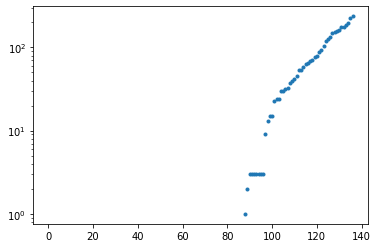

Poland [136]


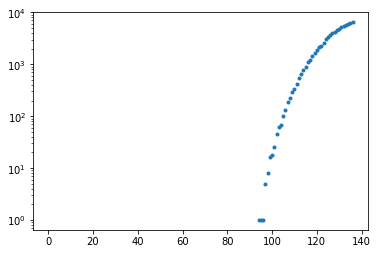

St. Vincent and the Grenadines [131 132 133 134 135 136]


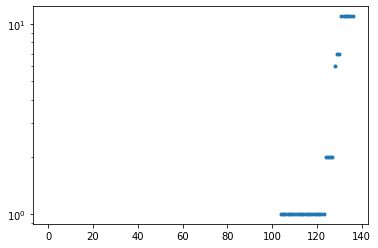

Liberia [135 136]


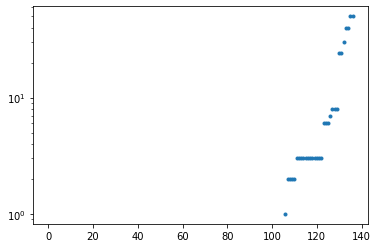

Spain [136]


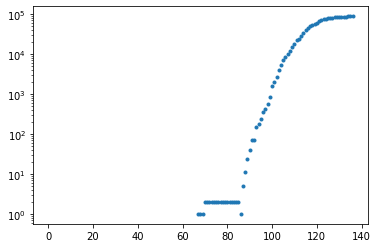

Pakistan [136]


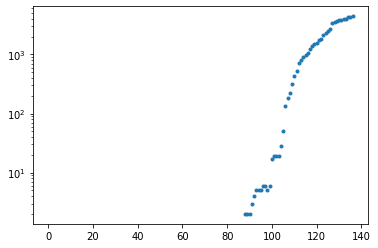

Mali [135 136]


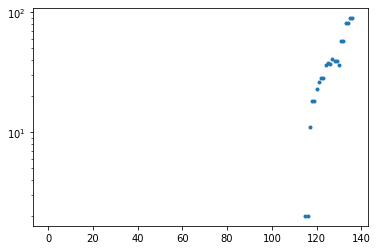

Madagascar [132 133]


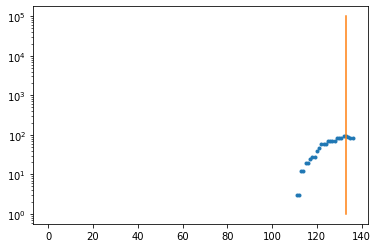

Zimbabwe [135 136]


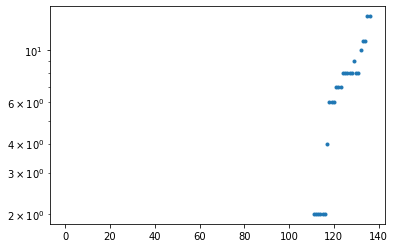

Sierra Leone [136]


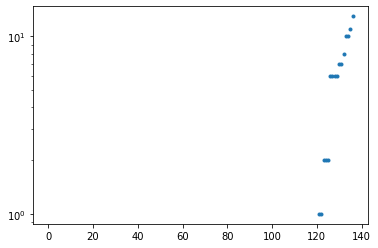

United Kingdom [136]


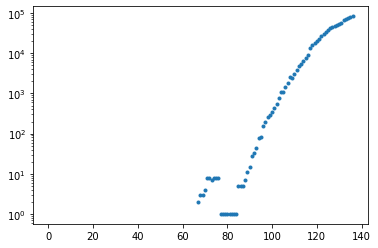

Central African Republic [133 134 135 136]


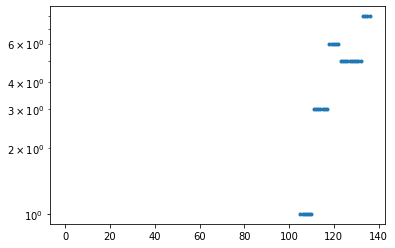

Burundi [133 134 135 136]


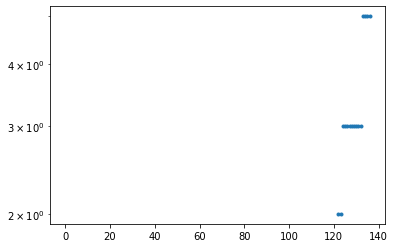

Estonia [136]


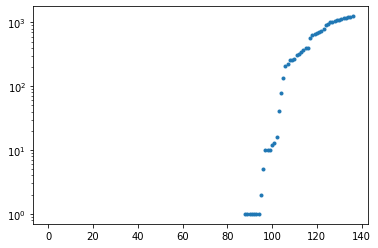

Iceland [127 128]


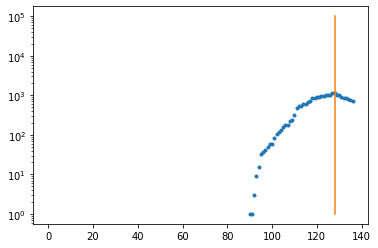

Northern Mariana Islands [136]


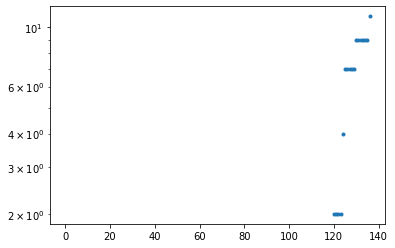

Chile [136]


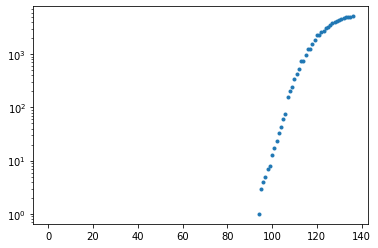

French Guiana [130 131 132]


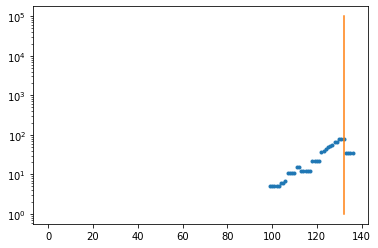

Monaco [134 135 136]


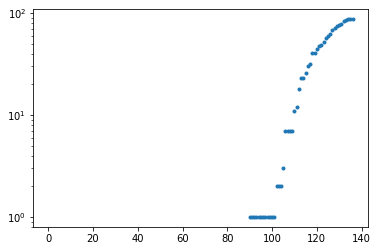

Philippines [136]


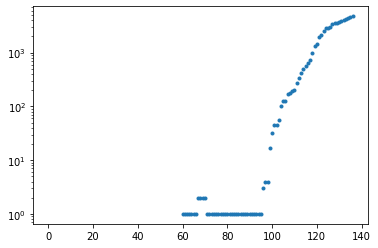

Zambia [123]


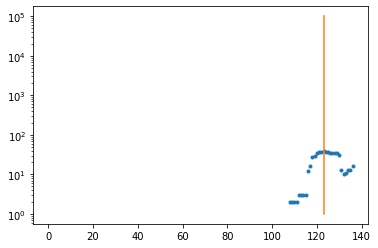

San Marino [136]


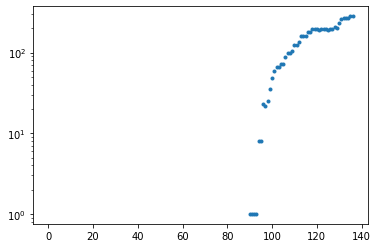

Trinidad and Tobago [131 132]


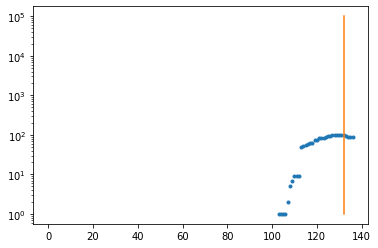

Djibouti [136]


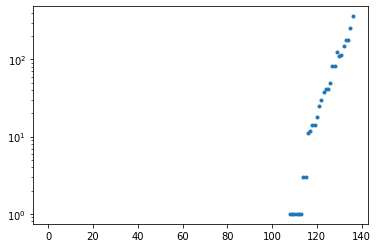

Mauritania [118 119 120 121]


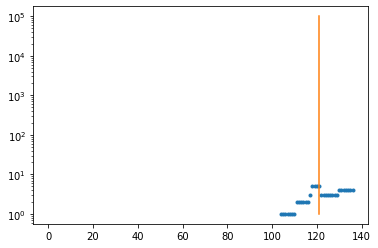

Ireland [136]


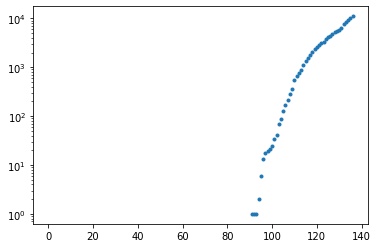

Myanmar [136]


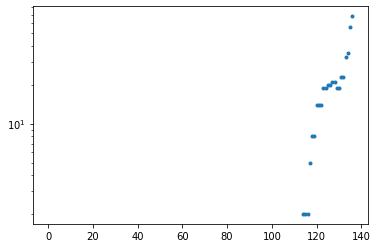

Vatican [124 125 126 127 128 129]


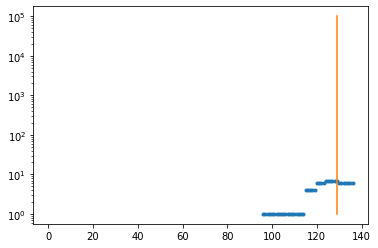

Ukraine [136]


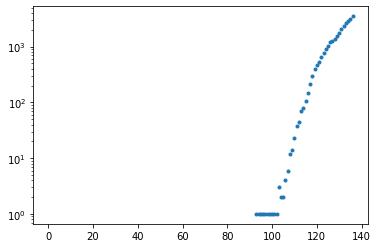

Afghanistan [136]


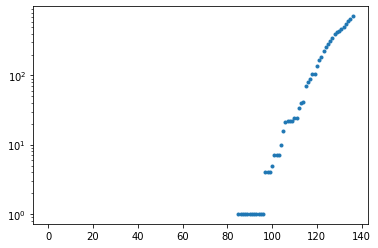

Laos [133 134 135 136]


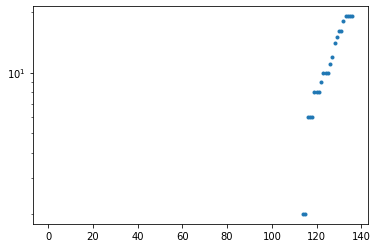

Israel [136]


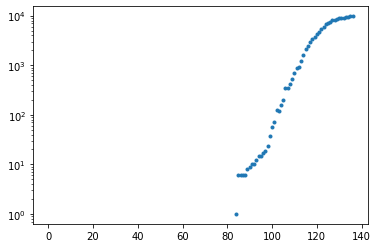

Greenland [128 129]


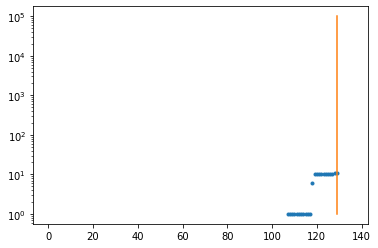

Kenya [135]


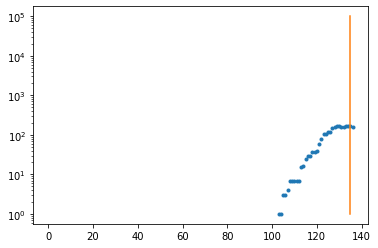

Mongolia [135 136]


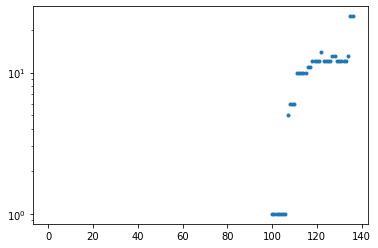

Cabo Verde [136]


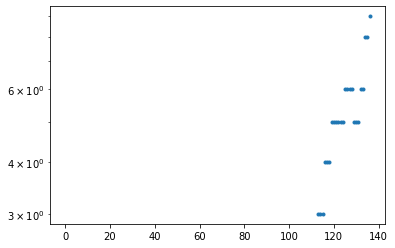

Guatemala [136]


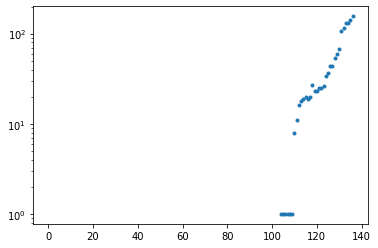

Anguilla [126 127 128 129 130 131 132 133 134 135 136]


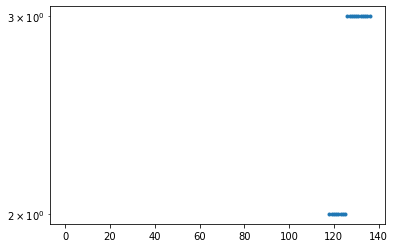

Yemen [131 132 133 134 135 136]


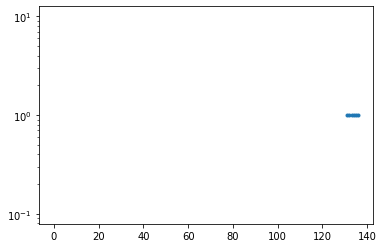

Honduras [136]


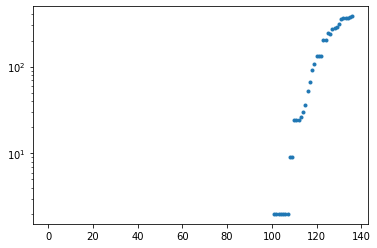

New Caledonia [125 126 127 128 129 130 131 132]


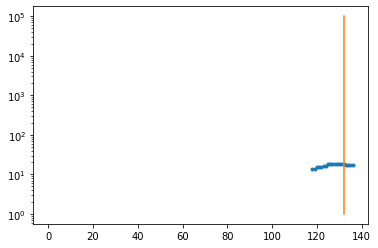

Algeria [129]


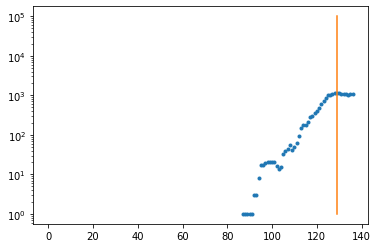

Libya [136]


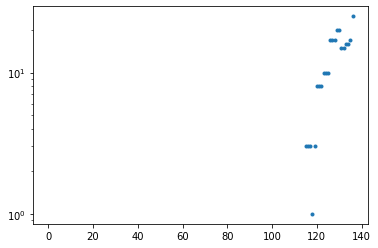

Benin [132 133 134 135 136]


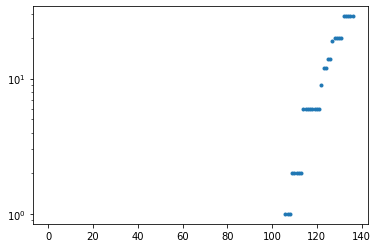

India [136]


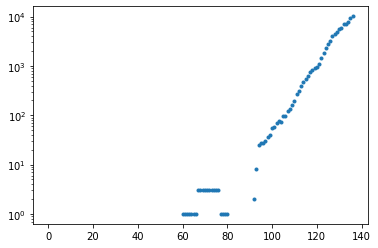

Russia [136]


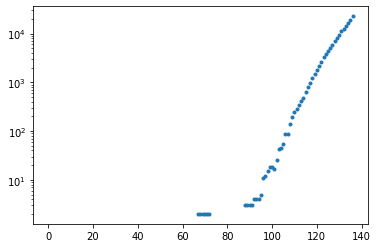

Argentina [136]


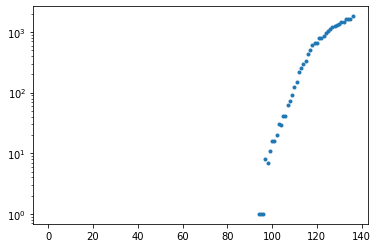

Jordan [124]


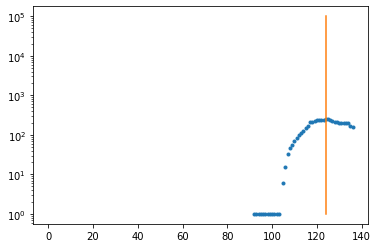

Eritrea [136]


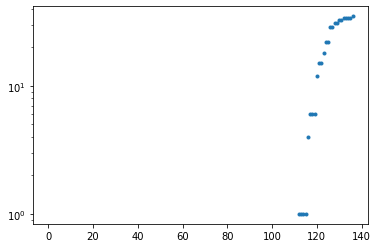

Syria [135 136]


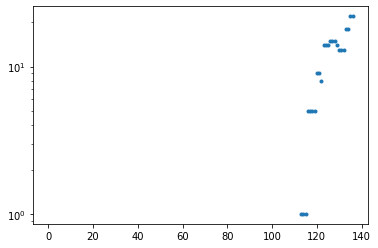

Australia [127]


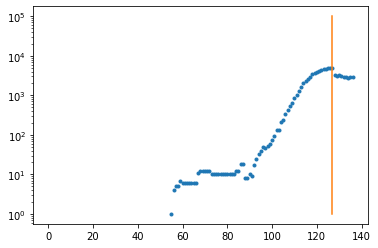

China [78]


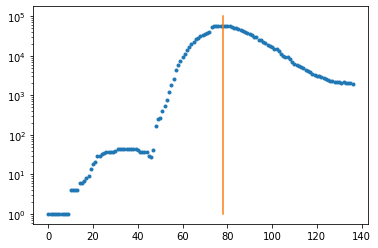

Lebanon [136]


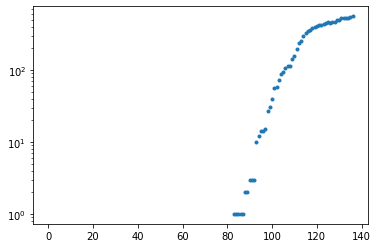

Senegal [125]


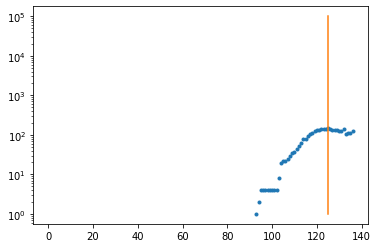

Denmark [135]


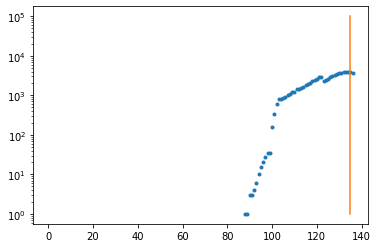

Mayotte [130]


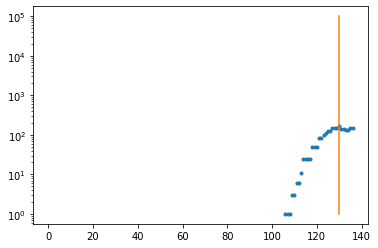

Iran [129]


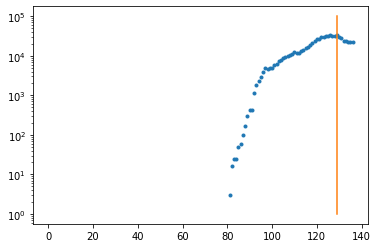

Nicaragua [133 134 135 136]


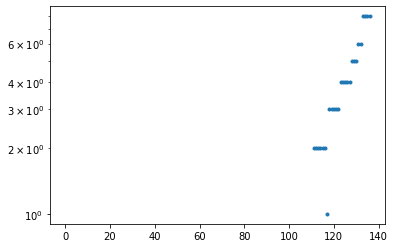

Ethiopia [136]


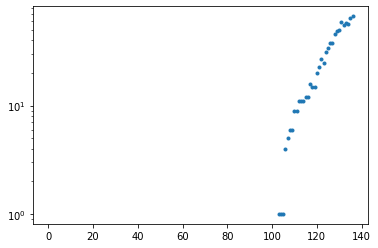

Aruba [130 131]


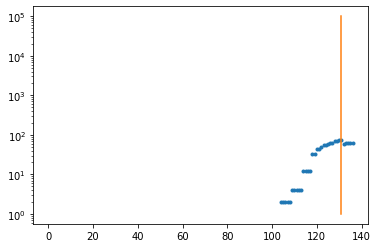

Nigeria [136]


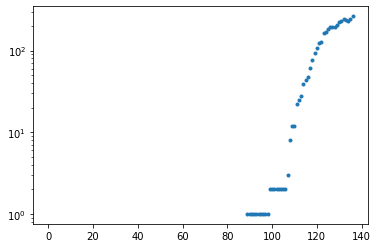

Belgium [136]


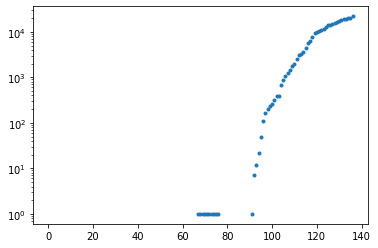

Saudi Arabia [136]


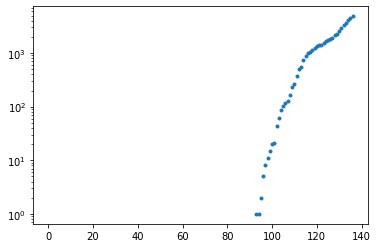

Cayman Islands [135 136]


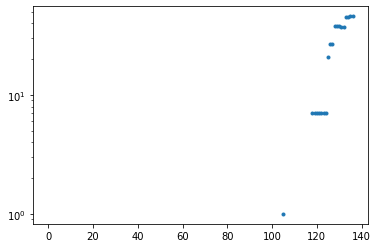

El Salvador [136]


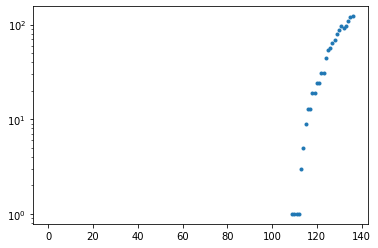

Chad [135 136]


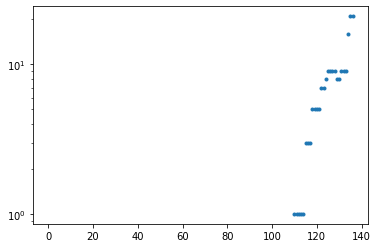

Papua New Guinea [127 128 129 130 131 132 133 134 135 136]


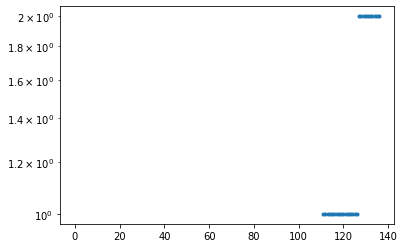

St. Kitts and Nevis [136]


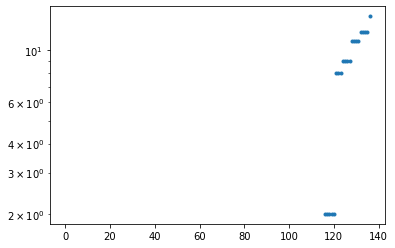

Cambodia [119]


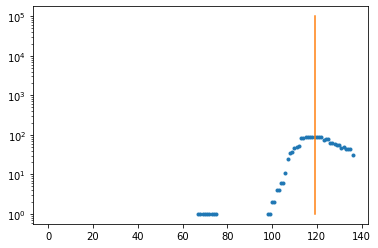

Guernsey [135 136]


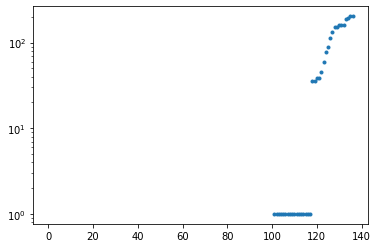

United States [136]


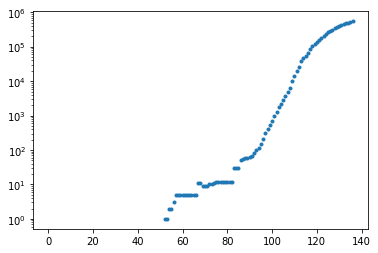

Portugal [136]


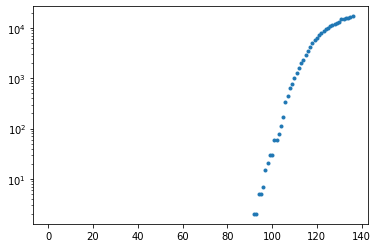

United States Virgin Islands [134 135 136]


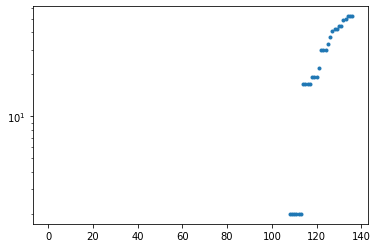

Brunei Darussalam [116]


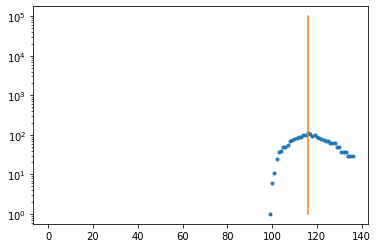

Azerbaijan [135]


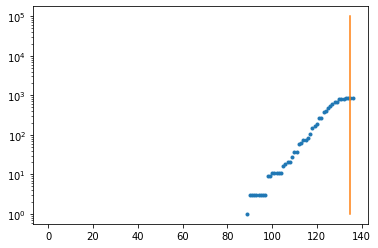

Kazakhstan [136]


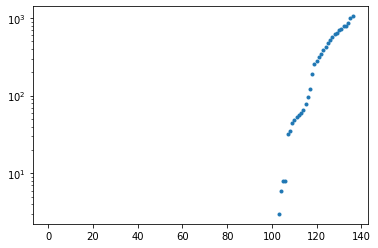

St. Lucia [132 133 134 135 136]


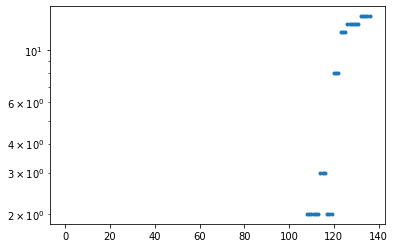

Belarus [136]


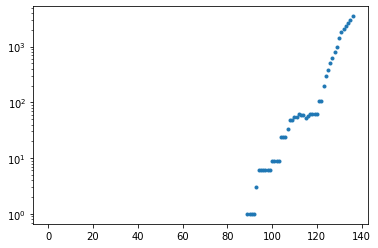

Cote d'Ivoire [135]


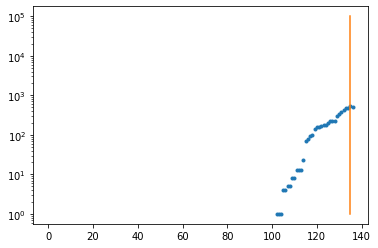

France [136]


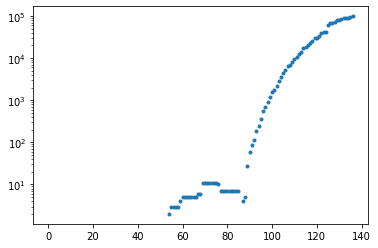

Tanzania [136]


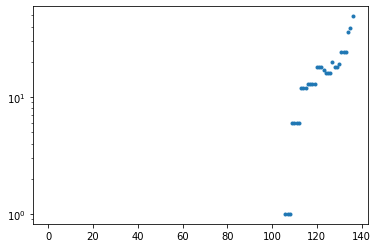

Colombia [136]


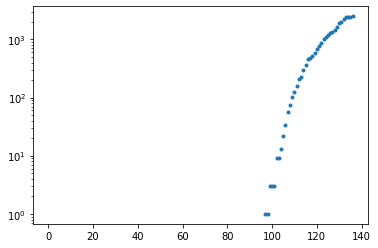

Serbia [135 136]


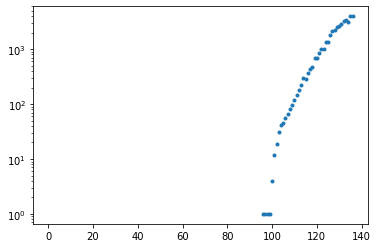

Jersey [134 135 136]


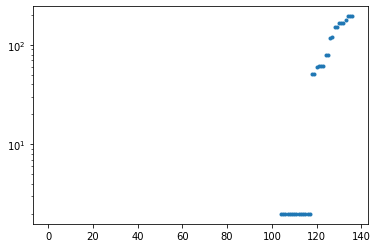

Falkland Islands [136]


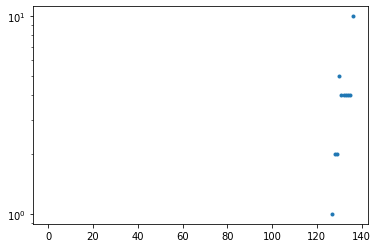

Costa Rica [135]


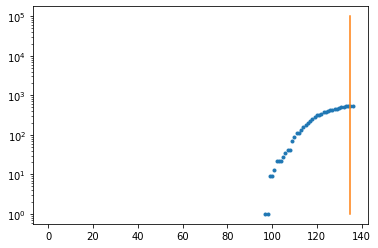

Latvia [136]


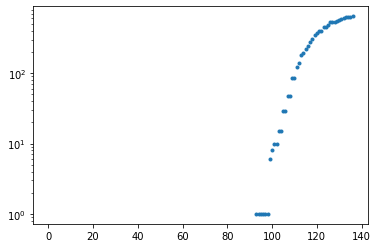

United Arab Emirates [136]


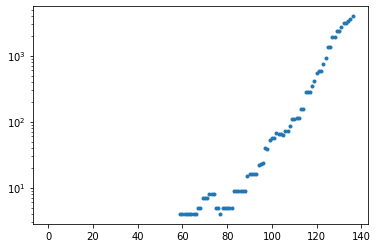

Brazil [135]


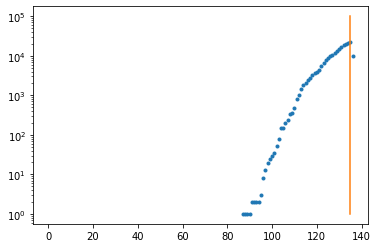

Tunisia [136]


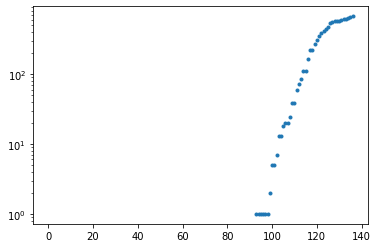

Andorra [131]


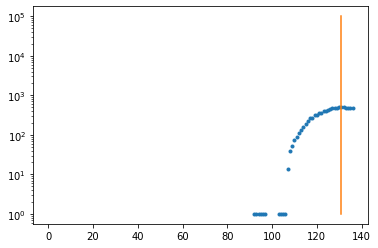

Bangladesh [136]


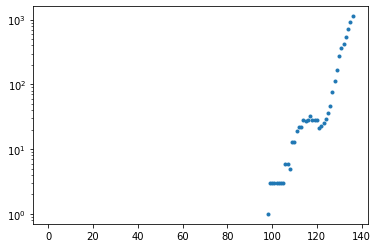

Egypt [136]


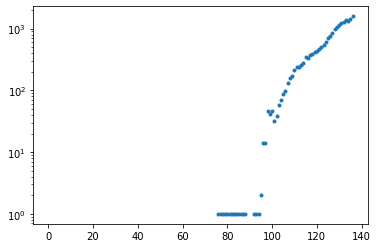

Guam [136]


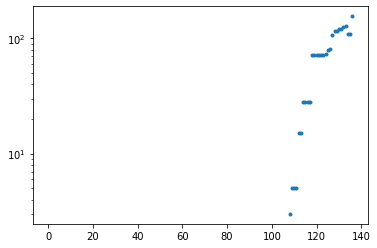

Morocco [136]


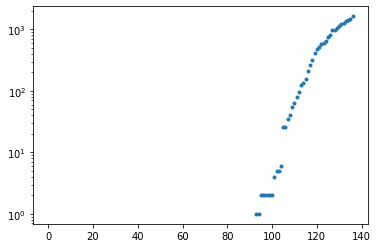

Palestine [135]


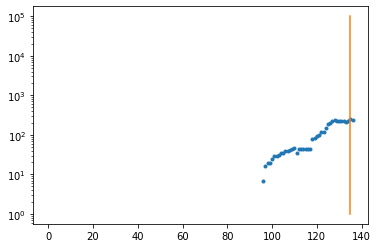

Togo [135]


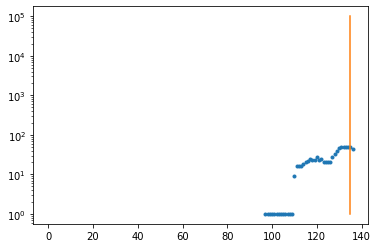

Qatar [136]


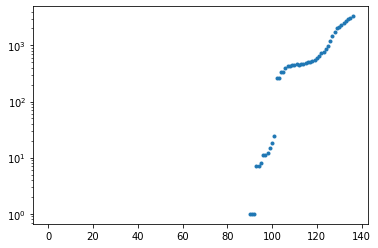

Belize [135 136]


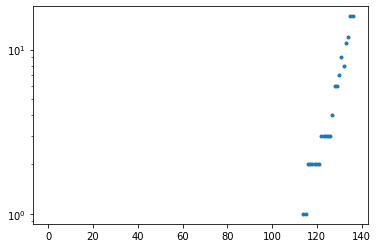

In [25]:
# 从现存确诊病例曲线上，推测出曲线开始下降的时间点，每个国家都不同
t0s = np.ones(len(nodes)) * all_cumconfirm_cases.shape[0]
for c,i in nodes.items():
    #flushPrint(i)
    curve = all_cumconfirm_cases[:,i]
    
    if max(curve)>0:
        maxv = max(curve)
        indx = np.nonzero(curve == maxv)[0]
        print(c,indx)
        plt.semilogy(curve,'.')
        if indx[-1] < len(curve) - 1:
            xs = np.ones(100) * indx[-1]
            ys = np.logspace(0, 5, 100)
            t0s[i] = indx[-1] - 5
            plt.semilogy(xs, ys)
        plt.show()
#输出一个数组t0s，记录了每个国家开始下降的时间点，如果没有下降，则为最后的时间点。

### 下面的代码尝试寻找t0s和新增病例数的规律，没有发现任何规律

In [63]:
bools = t0s<137

t0i = np.nonzero(bools)[0]
xx = []
yy = []
for t00 in t0i:
    first_found = np.nonzero(all_confirmed_cases[:, t00] > 0)[0][0]
    #xx.append(all_confirmed_cases[int(t0s[t00]), t00]/population[t00])
    diffa = np.r_[all_confirmed_cases[0:1, t00], np.diff(all_confirmed_cases[:, t00])]
    xx.append(diffa[int(t0s[t00])])
    yy.append(t0s[t00]-first_found)

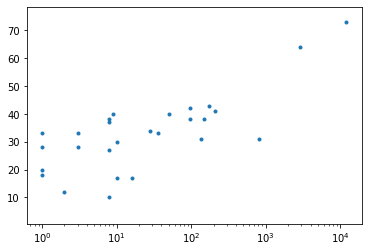

In [64]:
plt.semilogx(xx, yy, '.')

4.247465858357831 19.77921398375828 0.752657357786481
0.46059228609246544


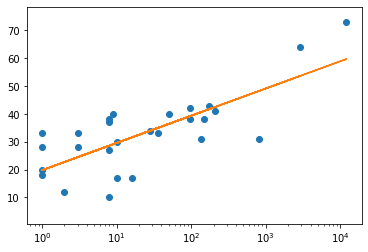

In [77]:
from scipy import stats
xx = np.array(xx)
yy = np.array(yy)
bools = xx>0
xxx = np.log(xx[bools])
yyy = yy[bools]
slope, intercept, r_value, p_value, std_err = stats.linregress(xxx,yyy)
print(slope,intercept, r_value)
print(std_err*1.96/np.sqrt(10))
plt.semilogx(xx,yy,'o')
plt.semilogx(np.exp(xxx), slope*xxx+intercept,'-')

### All data output

In [78]:
# 将所有的有用数据输出到文件中
# 参数说明：
#1、first_date：2020年1月1日，是我们的时间0点
#2、start_date: 2019年12月1日，是病例数据起始的0点
#3、all_cumconfirm_cases: 是一个time_length*国家数的而为数组，记录了某一天现存的确诊病例数，这里time_length就是12-1日到4-15日的时间
#4、all_cumexist_cases：是一个time_length*国家数的而为数组，记录了某一天累积的确诊病例数
#6、mask：是一个Tensor，time_length*2*国家数维度，0-1矩阵，记录了targets是否>0的情况
#7、first_cases: 在2019年12月1日，中国的确诊病例数
#8、字典nodes，国家名称作为key，国家在nodes中的位置作为value，这个值也是后面各个数组的国家索引
#9、population，一个数组，各个国家的人口数
#10、fijt：一个列表，存储了从2019-12-1到2020-12-31的每一天的流量矩阵，其中fij表示从i国家到j国家的航空流量除以i国家的人口数

output = {'cases':[all_cumconfirm_cases, all_cumexist_cases, first_cases, first_date, start_date, time_cases],
          't0s': t0s, 'nodes': nodes, 'population': population, 'fijt': fijt}
f = open('all_data_4_15.pkl', 'wb')
pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)
f.close()
